In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00:00:0100:01


In [2]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
fixed_yaml = """
path: /kaggle/input/x-ray-contraband-detection-dataset
train: SPXray/images/train
val: SPXray/images/val
test: SPXray/images/test

nc: 12
names:
  - Baton
  - Pliers
  - Hammer
  - Powerbank
  - Scissors
  - Wrench
  - Gun
  - Bullet
  - Sprayer
  - HandCuffs
  - Knife
  - Lighter
"""

FIXED_YAML = "/kaggle/working/data_fixed.yaml"

with open(FIXED_YAML, "w") as f:
    f.write(fixed_yaml)


In [9]:
"""
Kaggle Training Script for Bone Fracture Segmentation Model
Modified version for Kaggle notebooks
"""

import os
import shutil
from pathlib import Path
from ultralytics import YOLO
import yaml

# Paths for Kaggle
BASE_DIR = Path("/kaggle/input/x-ray-contraband-detection-dataset")
# Try to find the YAML file - could be in data/ or root
if (BASE_DIR / "data" / "SPXray.yaml").exists():
    DATA_YAML_SOURCE = BASE_DIR / "data" / "SPXray.yaml"
elif (BASE_DIR / "SPXray.yaml").exists():
    DATA_YAML_SOURCE = BASE_DIR / "SPXray.yaml"
elif (BASE_DIR / "data.yaml").exists():
    DATA_YAML_SOURCE = BASE_DIR / "data.yaml"
else:
    DATA_YAML_SOURCE = Path("/kaggle/working/data_fixed.yaml")  # Fallback

DATA_YAML = Path("/kaggle/working/data_fixed.yaml")  # Fixed YAML will be saved here
OUTPUT_DIR = Path("/kaggle/working")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TRAINING_OUTPUT_DIR = OUTPUT_DIR / "training"
TRAINING_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model files
BEST_MODEL_PATH = OUTPUT_DIR / "best.pt"
LAST_MODEL_PATH = OUTPUT_DIR / "last.pt"

def fix_yaml_paths(source_yaml, output_yaml, base_dir):
    """Fix relative paths in YAML to absolute paths"""
    print(f"\nLoading YAML from: {source_yaml}")
    with open(source_yaml, 'r') as f:
        config = yaml.safe_load(f)
    
    print(f"\nOriginal YAML paths:")
    print(f"  Train: {config.get('train', 'N/A')}")
    print(f"  Val: {config.get('val', 'N/A')}")
    print(f"  Test: {config.get('test', 'N/A')}")
    
    # Determine the base path for relative paths
    # If YAML is in data/ folder, relative paths are from data/
    # If YAML is in root, relative paths are from root
    if "data" in str(source_yaml):
        yaml_base = source_yaml.parent  # data/ folder
    else:
        yaml_base = base_dir
    
    # Fix paths - convert relative to absolute
    if 'train' in config:
        train_path = Path(config['train'])
        if not train_path.is_absolute():
            # Resolve relative to YAML location
            absolute_train = (yaml_base / train_path).resolve()
            config['train'] = str(absolute_train)
        else:
            config['train'] = str(Path(config['train']).resolve())
    
    if 'val' in config:
        val_path = Path(config['val'])
        if not val_path.is_absolute():
            absolute_val = (yaml_base / val_path).resolve()
            config['val'] = str(absolute_val)
        else:
            config['val'] = str(Path(config['val']).resolve())
    
    if 'test' in config:
        test_path = Path(config['test'])
        if not test_path.is_absolute():
            absolute_test = (yaml_base / test_path).resolve()
            config['test'] = str(absolute_test)
        else:
            config['test'] = str(Path(config['test']).resolve())
    
    # Save fixed YAML
    with open(output_yaml, 'w') as f:
        yaml.dump(config, f, default_flow_style=False, sort_keys=False, allow_unicode=True)
    
    print(f"\nFixed YAML saved to: {output_yaml}")
    print(f"  Train: {config['train']}")
    print(f"  Val: {config.get('val', 'N/A')}")
    print(f"  Test: {config.get('test', 'N/A')}")
    
    # Verify paths exist
    print("\nVerifying paths:")
    for split in ['train', 'val', 'test']:
        if split in config:
            path = Path(config[split])
            if path.exists():
                img_count = len(list(path.glob("*.jpg"))) + len(list(path.glob("*.png")))
                print(f"  ✓ {split}: {path} ({img_count} images)")
            else:
                print(f"  ✗ {split}: {path} (NOT FOUND)")
    
    return output_yaml

def train_model():
    """Train YOLOv8 segmentation model"""
    print("=" * 60)
    print("Bone Fracture Segmentation Model Training (Kaggle)")
    print("=" * 60)
    
    # Fix YAML paths
    print(f"\nSource YAML: {DATA_YAML_SOURCE}")
    fixed_yaml = fix_yaml_paths(DATA_YAML_SOURCE, DATA_YAML, BASE_DIR)
    
    # Load data config
    with open(fixed_yaml, 'r') as f:
        config = yaml.safe_load(f)
    
    print(f"\nDataset Configuration:")
    print(f"  Classes: {config['nc']}")
    print(f"  Class names: {config['names']}")
    print(f"  Data YAML: {fixed_yaml}")
    
    # Initialize model - using yolov8s-seg for better accuracy
    # Can use yolov8m-seg.pt or yolov8l-seg.pt for even better accuracy
    model_name = "yolo12s.pt"  # Small model for good balance
    print(f"\nLoading model: {model_name}")
    model = YOLO(model_name)
    
    # Training parameters optimized for accuracy
    print("\nTraining Parameters:")
    print("  Model: YOLOv8-seg (Segmentation)")
    print("  Epochs: 20")
    print("  Image size: 640")
    print("  Batch size: Auto")
    print("  Learning rate: 0.01")
    print("  Augmentation: Enabled")
    print("  Early stopping: Enabled (patience=50)")
    
    # Delete old best model if exists
    if BEST_MODEL_PATH.exists():
        try:
            BEST_MODEL_PATH.unlink()
            print(f"\nDeleted existing best model at {BEST_MODEL_PATH}")
        except Exception as e:
            print(f"Warning: Could not delete old best model: {e}")
    
    # Train the model
    try:
        results = model.train(
            data=str(fixed_yaml),
            epochs=20,
            imgsz=640,
            batch=-1,  # Auto batch size
            lr0=0.01,
            lrf=0.01,
            momentum=0.937,
            weight_decay=0.0005,
            warmup_epochs=3.0,
            warmup_momentum=0.8,
            warmup_bias_lr=0.1,
            box=7.5,
            cls=0.5,
            dfl=1.5,
            pose=12.0,
            kobj=1.0,
            label_smoothing=0.0,
            nbs=64,
            hsv_h=0.015,
            hsv_s=0.7,
            hsv_v=0.4,
            degrees=0.0,
            translate=0.1,
            scale=0.5,
            shear=0.0,
            perspective=0.0,
            flipud=0.0,
            fliplr=0.5,
            mosaic=1.0,
            mixup=0.0,
            copy_paste=0.0,
            auto_augment='randaugment',
            erasing=0.4,
            crop_fraction=1.0,
            patience=50,  # Early stopping patience
            save=True,
            save_period=10,
            val=True,
            plots=True,
            project=str(OUTPUT_DIR),
            name="training",
            exist_ok=True,
            pretrained=True,
            optimizer='auto',
            verbose=True,
            seed=0,
            deterministic=True,
            single_cls=False,
            rect=False,
            cos_lr=False,
            close_mosaic=10,
            resume=False,
            amp=True,
            fraction=1.0,
            profile=False,
            freeze=None,
            # Segmentation specific
            overlap_mask=True,
            mask_ratio=4,
            dropout=0.0,
        )
        
        print("\n" + "=" * 60)
        print("Training completed successfully!")
        print("=" * 60)
        
        # YOLOv8 saves models in the project/name/weights/ directory
        # Since we set project=OUTPUT_DIR and name="training", models should be in:
        # OUTPUT_DIR/training/weights/
        weights_dir = OUTPUT_DIR / "training" / "weights"
        
        # Also check runs directory (default YOLOv8 location)
        if not weights_dir.exists():
            weights_dir = Path("runs") / "seg" / "training" / "weights"
        
        # If still not found, search recursively
        if not weights_dir.exists():
            training_dirs = list(OUTPUT_DIR.rglob("**/weights"))
            if training_dirs:
                # Get the most recently modified weights directory
                weights_dir = max(training_dirs, key=lambda x: x.stat().st_mtime if x.exists() else 0)
        
        if weights_dir.exists():
            best_in_runs = weights_dir / "best.pt"
            last_in_runs = weights_dir / "last.pt"
            
            # Copy best model (delete old first)
            if best_in_runs.exists():
                if BEST_MODEL_PATH.exists():
                    BEST_MODEL_PATH.unlink()
                shutil.copy(best_in_runs, BEST_MODEL_PATH)
                print(f"\nBest model saved to: {BEST_MODEL_PATH}")
            else:
                print(f"\nWarning: best.pt not found in {weights_dir}")
            
            # Copy last model
            if last_in_runs.exists():
                if LAST_MODEL_PATH.exists():
                    LAST_MODEL_PATH.unlink()
                shutil.copy(last_in_runs, LAST_MODEL_PATH)
                print(f"Last model saved to: {LAST_MODEL_PATH}")
            else:
                print(f"Warning: last.pt not found in {weights_dir}")
        else:
            print(f"\nWarning: Could not find weights directory. Models may be in a different location.")
            print(f"Searched in: {OUTPUT_DIR / 'training' / 'weights'}")
            print(f"Please check the YOLOv8 output directory for model files.")
        
        # Copy training plots
        # Find results.png in training directories
        possible_plot_paths = [
            Path("runs") / "seg" / "training" / "results.png",
            OUTPUT_DIR / "training" / "results.png",
            OUTPUT_DIR / "training" / "train" / "results.png",
        ]
        
        for plot_path in possible_plot_paths:
            if plot_path.exists():
                shutil.copy(plot_path, TRAINING_OUTPUT_DIR / "training_results.png")
                print(f"Training plots saved to: {TRAINING_OUTPUT_DIR / 'training_results.png'}")
                break
        
        # Also search recursively
        if not (TRAINING_OUTPUT_DIR / "training_results.png").exists():
            for results_file in OUTPUT_DIR.rglob("results.png"):
                shutil.copy(results_file, TRAINING_OUTPUT_DIR / "training_results.png")
                print(f"Training plots saved to: {TRAINING_OUTPUT_DIR / 'training_results.png'}")
                break
        
        # Print final metrics
        if hasattr(results, 'results_dict'):
            print("\nFinal Training Metrics:")
            for key, value in results.results_dict.items():
                if isinstance(value, (int, float)):
                    print(f"  {key}: {value:.4f}")
        
        print(f"\nAll outputs saved to: {OUTPUT_DIR}")
        print("=" * 60)
        
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    train_model()



Bone Fracture Segmentation Model Training (Kaggle)

Source YAML: /kaggle/input/x-ray-contraband-detection-dataset/data/SPXray.yaml

Loading YAML from: /kaggle/input/x-ray-contraband-detection-dataset/data/SPXray.yaml

Original YAML paths:
  Train: ./images/train
  Val: ./images/val
  Test: ./images/test

Fixed YAML saved to: /kaggle/working/data_fixed.yaml
  Train: /kaggle/input/x-ray-contraband-detection-dataset/data/images/train
  Val: /kaggle/input/x-ray-contraband-detection-dataset/data/images/val
  Test: /kaggle/input/x-ray-contraband-detection-dataset/data/images/test

Verifying paths:
  ✓ train: /kaggle/input/x-ray-contraband-detection-dataset/data/images/train (10982 images)
  ✓ val: /kaggle/input/x-ray-contraband-detection-dataset/data/images/val (1373 images)
  ✓ test: /kaggle/input/x-ray-contraband-detection-dataset/data/images/test (1373 images)

Dataset Configuration:
  Classes: 12
  Class names: ['Baton', 'Plier', 'Hammer', 'Powerbank', 'Scissors', 'Wrench', 'Gun', 'Bulle

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1373       1794        0.9      0.856      0.914      0.764
                 Baton        143        148      0.955      0.953      0.959       0.83
                 Plier        142        168      0.882      0.756      0.875      0.657
                Hammer        135        142       0.95      0.944      0.977      0.923
             Powerbank        147        154      0.887      0.929       0.96        0.8
              Scissors        157        166      0.849      0.845      0.901      0.669
                Wrench        119        135      0.909      0.813       0.92      0.792
                   Gun        124        143      0.882       0.89       0.93      0.684
                Bullet        162        162      0.917      0.889       0.95      0.796
               Sprayer        144        146      0.971      0.923      0.969      0.885
             HandCuffs        156        156      0.972      0.987      0.987      0.929
                 Knif

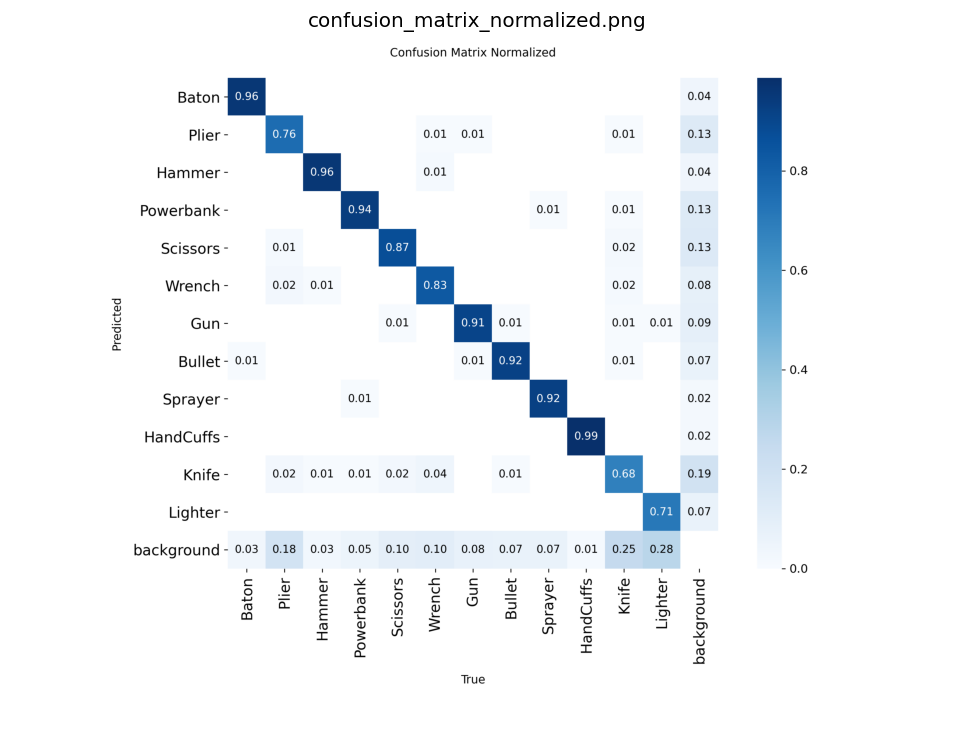

[HATA] Dosya bulunamadı: /kaggle/working/training/F1_curve.png
[HATA] Dosya bulunamadı: /kaggle/working/training/P_curve.png
[HATA] Dosya bulunamadı: /kaggle/working/training/R_curve.png
[HATA] Dosya bulunamadı: /kaggle/working/training/PR_curve.png


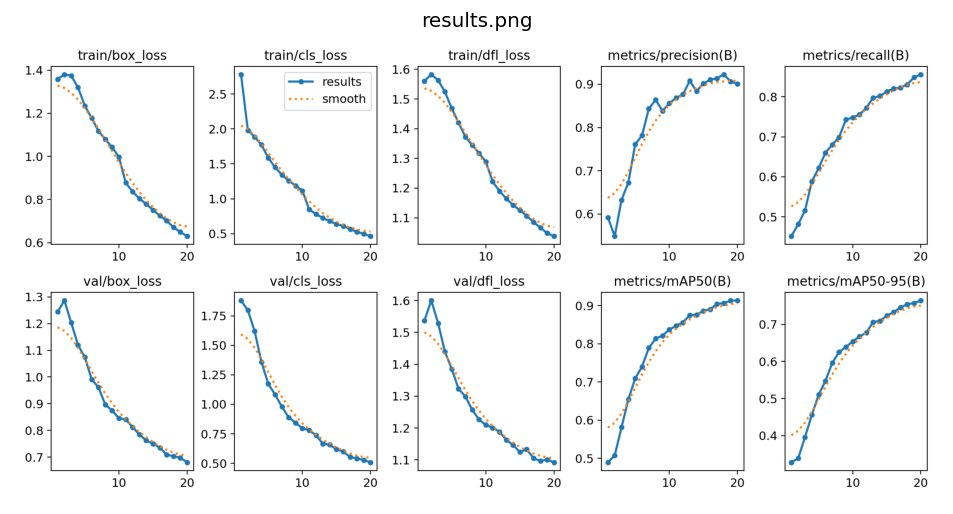

In [12]:
import os
import cv2
import matplotlib.pyplot as plt

def display_images(post_training_files_path, image_files):
    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)

        if not os.path.exists(image_path):
            print(f"[HATA] Dosya bulunamadı: {image_path}")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"[HATA] Görüntü okunamadı: {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = '/kaggle/working/training'

# Display the images
display_images(post_training_files_path, image_files)

In [13]:
# === Paths ===
VAL_IMAGE_DIR = "/kaggle/input/x-ray-contraband-detection-dataset/data/images/val"
MODEL_PATH    = "/kaggle/working/training/weights/best.pt"  # or wherever your model is

# === Load trained model ===
model = YOLO(MODEL_PATH)

In [14]:
# === Collect validation images ===
val_images = [os.path.join(VAL_IMAGE_DIR, f)
              for f in os.listdir(VAL_IMAGE_DIR)
              if f.lower().endswith((".png", ".jpg", ".jpeg"))]

In [15]:
import random
# === Sample  random images ===
sampled = random.sample(val_images, min(30, len(val_images)))

In [16]:
# === Run inference ===
results = model(sampled)


0: 640x640 2 Wrenchs, 6.7ms
1: 640x640 1 Bullet, 6.7ms
2: 640x640 1 Wrench, 6.7ms
3: 640x640 1 Bullet, 2 HandCuffss, 6.7ms
4: 640x640 1 Sprayer, 6.7ms
5: 640x640 1 Lighter, 6.7ms
6: 640x640 1 Bullet, 6.7ms
7: 640x640 1 Hammer, 6.7ms
8: 640x640 1 Sprayer, 6.7ms
9: 640x640 1 Bullet, 6.7ms
10: 640x640 1 Plier, 6.7ms
11: 640x640 1 Plier, 1 Wrench, 6.7ms
12: 640x640 3 Guns, 6.7ms
13: 640x640 2 Guns, 3 Knifes, 6.7ms
14: 640x640 4 Pliers, 1 Wrench, 1 Gun, 6.7ms
15: 640x640 1 Gun, 1 Bullet, 6.7ms
16: 640x640 1 Hammer, 6.7ms
17: 640x640 1 Sprayer, 6.7ms
18: 640x640 1 Lighter, 6.7ms
19: 640x640 1 Lighter, 6.7ms
20: 640x640 1 Hammer, 6.7ms
21: 640x640 1 Powerbank, 6.7ms
22: 640x640 1 Scissors, 6.7ms
23: 640x640 1 Plier, 1 Gun, 6.7ms
24: 640x640 1 Hammer, 6.7ms
25: 640x640 1 Bullet, 6.7ms
26: 640x640 1 Scissors, 6.7ms
27: 640x640 1 Hammer, 1 Wrench, 6.7ms
28: 640x640 1 Scissors, 6.7ms
29: 640x640 1 Knife, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 0.7ms postprocess per image at shape (1, 3, 

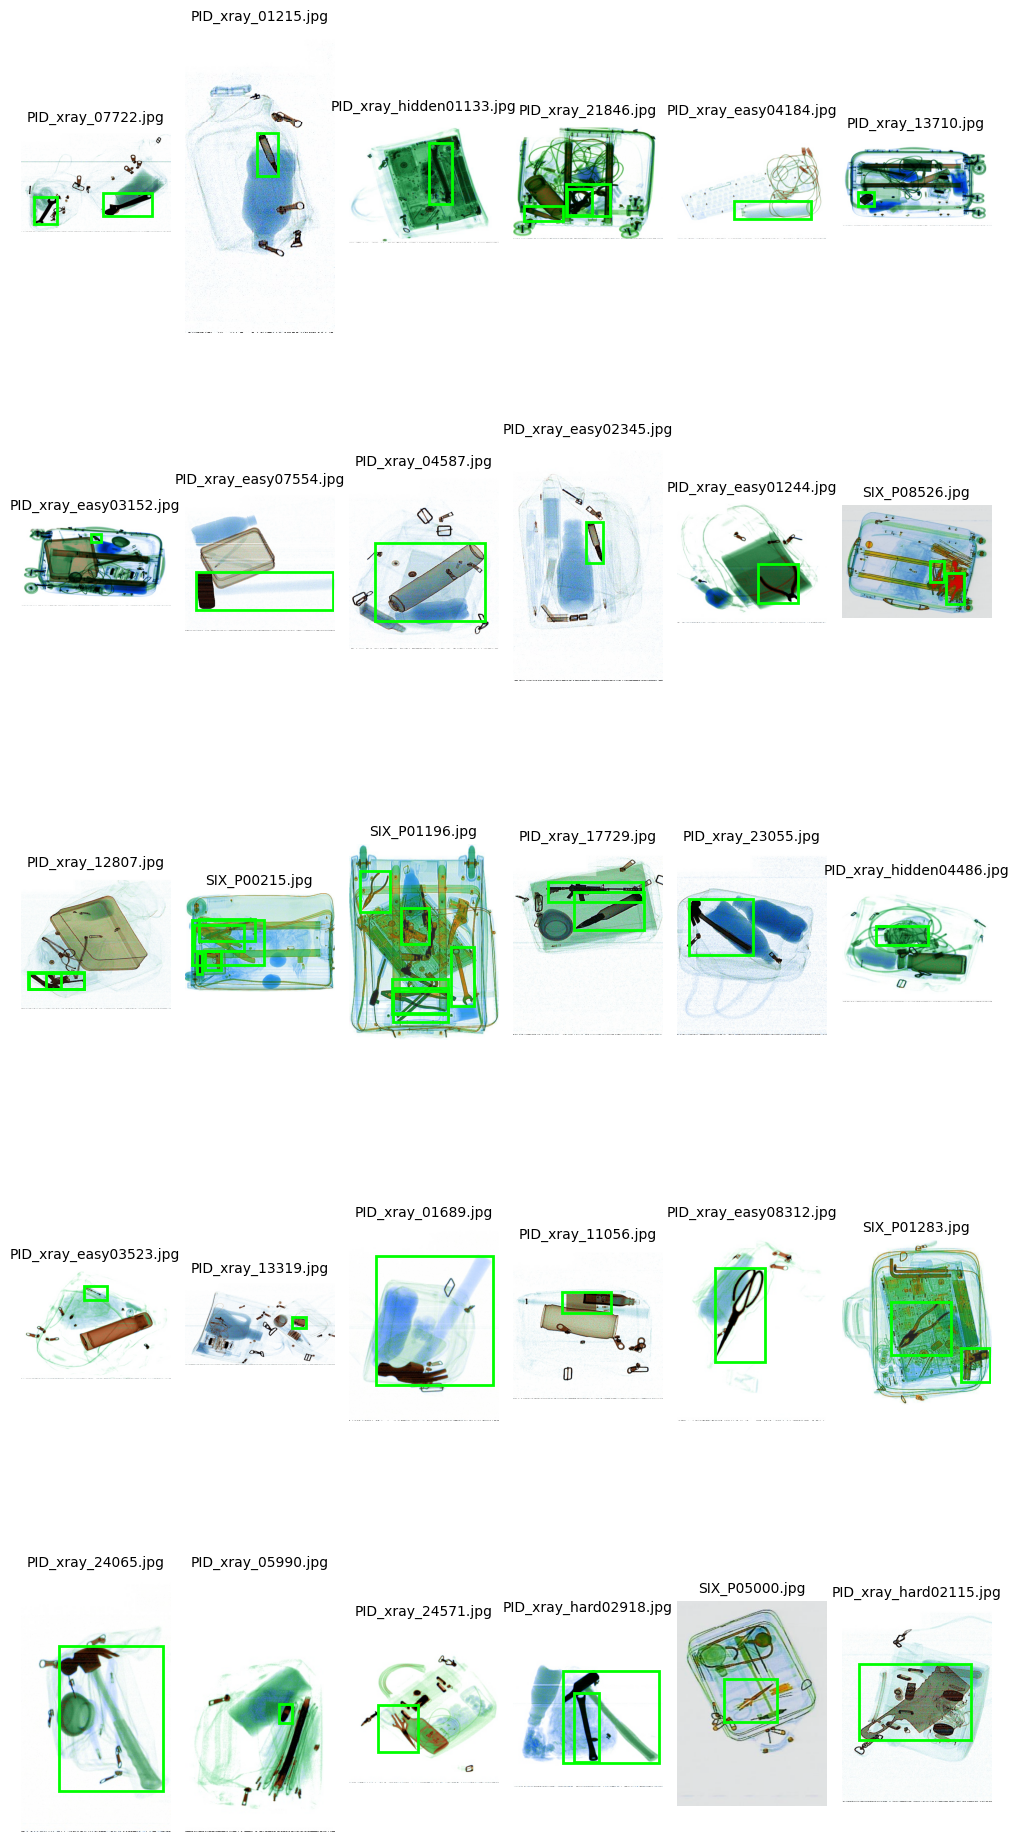

In [17]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
# === Plotting (6 rows × 4 columns) ===
fig, axes = plt.subplots(5, 6, figsize=(10, 20))
axes = axes.flatten()

for ax, result in zip(axes, results):
    img = result.orig_img  # NumPy image
    boxes = result.boxes

    ax.imshow(img, cmap="gray" if len(img.shape) == 2 or img.shape[2] == 1 else None)

    if boxes is not None and boxes.xyxy is not None:
        for box in boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = box[:4]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor="lime", facecolor="none")
            ax.add_patch(rect)

    ax.set_title(os.path.basename(result.path), fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()